In [25]:
from ib_insync import *
import pandas as pd
from datetime import datetime, timedelta
import requests
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [26]:
util.startLoop()

In [ ]:
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1)


<IB connected to 127.0.0.1:7497 clientId=1>

Peer closed connection.


In [29]:
# Definir el contrato de GBP/USD
contract = Forex('GBPUSD')

# Establecer el rango de tiempo
end_time = datetime.now()
start_time = end_time - timedelta(days=30)

In [30]:
# Obtener datos históricos
bars = ib.reqHistoricalData(
    contract,
    endDateTime=end_time,
    durationStr='30 D',
    barSizeSetting='1 hour',
    whatToShow='MIDPOINT',
    useRTH=False
)

# Convertir los datos a DataFrame
df = util.df(bars)


In [31]:
# Clave de API de News API (regístrate para obtener una clave)
API_KEY = 'b35c56d955ee45178c703f7f79c1dfca'

In [32]:
# Obtener noticias recientes relacionadas con GBP/USD
news_url = f'https://newsapi.org/v2/everything?q=GBP%20USD&apiKey={API_KEY}'
response = requests.get(news_url)


In [33]:
# Parsear la respuesta JSON
news_data = response.json()

In [34]:

# Extraer titulares relevantes
titles = [article['title'] for article in news_data['articles']]
print(f"Titulares de noticias relevantes:\n {titles}")

Titulares de noticias relevantes:
 ["Samsung Announces a Trio of New 'Galaxy A' Smartphones", 'Lamborghini Just Launched a $5,000 Baby Stroller', 'The King Seiko Vanac Collection Draws Inspiration From Tokyo’s Mesmerizing Skyline', 'Georg Jensen Presents A Trio of Sculptural Vases in New “Lituus” Collection', 'Seiko Celebrates 60 Years of the Prospex With a Trio of Limited Editions', 'Carl Friedrik and Hackett London Expand Their Collaborative Collection', 'Garmin Launches Instinct 3 Series', 'Nothing Announces Phone (3a) and Phone (3a) Pro', 'Patta and AVIREX Team Up to Reimagine the Icon Jacket', 'Perfect Phone for Kids? HMD X1 is the Safe, Repairable $290 Smartphone Parents Have Been Waiting For', 'Chargeasap Flash Pro Ultra Arrives as World’s First 275W Power Bank with Dual OLED Display', 'REDMAGIC Unveils the Golden Saga Limited Edition: A Luxury Gaming Powerhouse', '13 Google Ads Settings To Check When Running International PPC Campaigns via @sejournal, @brookeosmundson', 'BVNK L

In [35]:
# Contar palabras clave positivas y negativas
positive_keywords = ['increase', 'growth', 'positive']
negative_keywords = ['decline', 'decrease', 'negative']

positive_news = sum(1 for title in titles if any(word in title.lower() for word in positive_keywords))
negative_news = sum(1 for title in titles if any(word in title.lower() for word in negative_keywords))

In [36]:
# Impacto total en los precios (por ejemplo, 0.1% de ajuste por noticia positiva o negativa)
impact_factor = 1 + (positive_news - negative_news) * 0.001  # Ajusta el impacto según la cantidad de noticias


In [37]:
# Seleccionar las columnas relevantes
data = df[['open', 'high', 'low', 'close']].values


In [38]:
# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [39]:
# Ajustar los datos con el impacto de las noticias
scaled_data_adjusted = scaled_data * impact_factor

# Crear secuencias de entrenamiento para LSTM
sequence_length = 60
x_train, y_train = [], []

In [40]:

for i in range(sequence_length, len(scaled_data_adjusted)):
    x_train.append(scaled_data_adjusted[i-sequence_length:i])
    y_train.append(scaled_data_adjusted[i])

In [41]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [42]:
from tensorflow.keras.layers import Input

In [43]:

# Definir el modelo LSTM
model = Sequential()

# Agregar la capa de entrada
model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))

# Agregar capas LSTM y Dropout
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Capa densa para predicciones de open, high, low, close
model.add(Dense(units=4))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(x_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1027
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0151
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0091
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0083
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0082
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0079
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0077
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0069
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0069
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0071
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0070
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0061
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0058
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0059
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0055
Epoc

In [44]:
# Obtener datos recientes para predecir
recent_data = scaled_data_adjusted[-sequence_length:]

# Lista para almacenar las predicciones
predictions = []

In [ ]:
# Predecir desde las 10 p.m. hasta la 1 p.m. (16 horas)
for _ in range(10): # numero de iteraciones
    x_input = np.array([recent_data])
    predicted_price = model.predict(x_input)
    predictions.append(predicted_price[0])
    recent_data = np.append(recent_data[1:], [predicted_price[0]], axis=0)

# Desnormalizar las predicciones
predictions = scaler.inverse_transform(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [46]:
# Crear un DataFrame con las predicciones
prediction_times = [end_time.replace(hour=21, minute=0, second=0) + timedelta(hours=i) for i in range(1, 11)]
predicted_df = pd.DataFrame(predictions, columns=['open', 'high', 'low', 'close'], index=prediction_times)
print(predicted_df)

                                open      high       low     close
2025-03-12 22:00:00.449704  1.295088  1.296781  1.293920  1.295521
2025-03-12 23:00:00.449704  1.295063  1.296781  1.293901  1.295498
2025-03-13 00:00:00.449704  1.294977  1.296728  1.293822  1.295416
2025-03-13 01:00:00.449704  1.294853  1.296635  1.293700  1.295293
2025-03-13 02:00:00.449704  1.294703  1.296514  1.293549  1.295142
2025-03-13 03:00:00.449704  1.294538  1.296372  1.293381  1.294972
2025-03-13 04:00:00.449704  1.294363  1.296216  1.293200  1.294790
2025-03-13 05:00:00.449704  1.294183  1.296050  1.293013  1.294602
2025-03-13 06:00:00.449704  1.294000  1.295876  1.292823  1.294410
2025-03-13 07:00:00.449704  1.293815  1.295698  1.292630  1.294215


In [22]:
import matplotlib.pyplot as plt
import mplfinance as mpf

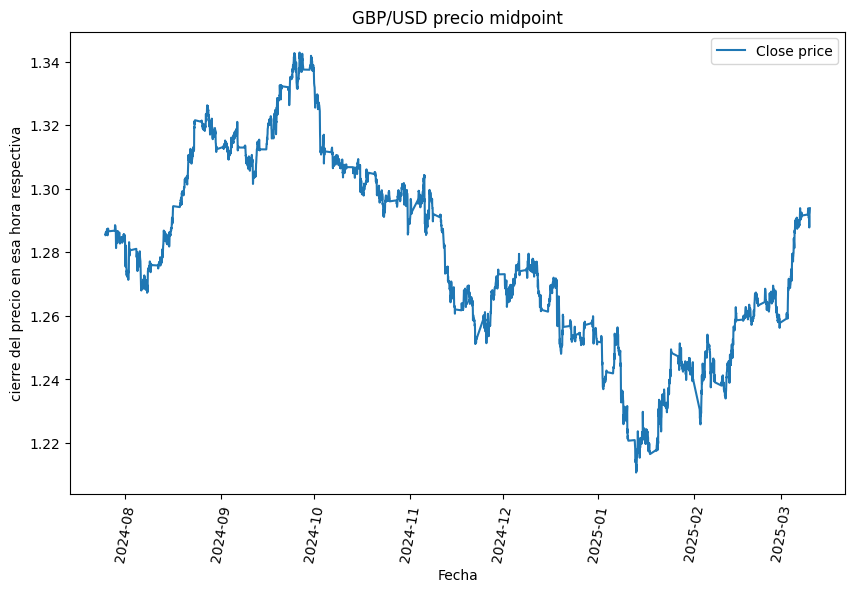

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['close'], label='Close price')

#Anadir titulos y etiquetas 
plt.title('GBP/USD precio midpoint')
plt.xlabel('Fecha')
plt.ylabel('cierre del precio en esa hora respectiva')
plt.xticks(rotation = 80)
plt.legend()

#Muestro mi ploteo
plt.show()

In [24]:
ib.disconnect()